In [129]:
import csv
import datetime
from statistics import mean
from sklearn.model_selection import cross_val_score, KFold
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models, Sequential, utils
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,classification_report, accuracy_score, plot_confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D,MaxPooling3D,BatchNormalization, MaxPool2D
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import logging, os
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import random
import pandas as pd

from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BayesianEstimator
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Read:
    def __init__(self,filename):
        self.reader = csv.reader(open(filename), delimiter = ",")
        self.data = list(self.reader)
        self.data.pop(0)

In [3]:
class Game:
    id = 0
    def __init__(self,data):
        Game.id += 1
        self.id = Game.id
        self.data = data
        index = 0
        for i in range(len(self.data)):
            try:
                self.data[i] = int(self.data[i])
            except:
                pass
        self.game_data = self.data[1:22]
        self.pregame_data = self.data[1:4]
        self.date = self.data[1]
        self.time = self.data[2]
        self.h_team = self.data[3]
        self.a_team = self.data[4]
        self.h_score = self.data[5]  
        self.a_score = self.data[6]
        if self.data[7] == "H":
            self.result = 0
        elif self.data[7] == "D":
            self.result = 1
        elif self.data[7] == "A":
            self.result = 2
        else:
            print("error")
        self.h_half_goals = self.data[8] #goals at half time
        self.a_half_goals = self.data[9] 
        self.half_result = self.data[10] 
        self.referee = self.data[11]
        self.h_shots = self.data[12]
        self.a_shots = self.data[13]
        self.h_shots_ontarg = self.data[14]
        self.a_shots_ontarg = self.data[15]
        self.h_fouls = self.data[16]
        self.a_fouls = self.data[17]
        self.h_corners = self.data[18]
        self.a_corners = self.data[19]
        self.h_yellow = self.data[20]
        self.a_yellow = self.data[21]
        self.h_red = self.data[22]
        self.a_red = self.data[23]

In [4]:
class Team:
    id = 0
    def __init__(self, name):
        Team.id += 1
        self.id = Team.id 
        self.name = name
        self.games = []
    
    def add_game(self,game):
        self.games.append(game)

    def get_id(self):
        return self.id
        
    def get_name(self):
        return self.name
    
    def get_games_before(self,game):
        games_before = []
        count = 0
        for i in self.games:
            if i == game:
                return self.games[:count]
            count+=1
        return []
    
    def get_stats(self,game_list):
        #stats avg([goals_scored,conceded,halfgoals,halfconceded,shots,
        #shotsgiven,shotson,shotsongiven,foulsgiven,fouls,corners,
        #cornersgiven,yellowgiven,yellow,redgiven,red])
        stats = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        game_count = 0
        
        for i in game_list:
            if (i.h_team == self.name):
                game_count += 1
                #our home stats
                stats[1] += i.h_score
                stats[2] += i.h_half_goals
                stats[3] += i.h_shots
                stats[4] += i.h_shots_ontarg
                stats[5] += i.h_fouls
                stats[6] += i.h_corners
                stats[7] += i.h_yellow
                stats[8] += i.h_red
                #opps away stats
                stats[9] += i.a_score
                stats[10] += i.a_half_goals
                stats[11] += i.a_shots
                stats[12] += i.a_shots_ontarg
                stats[13] += i.a_fouls
                stats[14] += i.a_corners
                stats[15] += i.a_yellow
                stats[16] += i.a_red
                
            if (i.a_team == self.name):
                game_count += 1 
                #our away stats
                stats[1] += i.a_score
                stats[2] += i.a_half_goals
                stats[3] += i.a_shots
                stats[4] += i.a_shots_ontarg
                stats[5] += i.a_fouls
                stats[6] += i.a_corners
                stats[7] += i.a_yellow
                stats[8] += i.a_red
                #opp's home stats
                stats[9] += i.h_score
                stats[10] += i.h_half_goals
                stats[11] += i.h_shots
                stats[12] += i.h_shots_ontarg
                stats[13] += i.h_fouls
                stats[14] += i.h_corners
                stats[15] += i.h_yellow
                stats[16] += i.h_red
        
        count = 0
        stats[0] = self.id;
        for j in range(1,len(stats)):
            count += 1
            if game_count !=0:
                stats[j] = round((stats[j])/game_count,2)
            else:
                stats = False
        #print(str(stats)+str(self.name));
        return stats
  
    def get_stats_before(self,game):
        game_list = self.get_games_before(game)
        stats = self.get_stats(game_list)
        return stats
    
Team.id = 0

In [42]:
read = Read("Data/19_20_data.csv")

games = list()
teams = list()
data = []
index = 0
labels = []
data1d = []
scores = []

for result in read.data:
    games.append(Game(result))
    found = False
    for i in teams:
        if i.get_name() == result[3]:
            found = True
            break
    if (found == False):
        teams.append(Team(result[3]))
    found = False
    
for team in teams:
    for game in games:
        if game.h_team == team.name or game.a_team == team.name:
            team.add_game(game)

for game in games:
    data.append([[],[]])
    data1d.append([])
    res = np.array(game.result)
    labels.append(res)
    scores.append([game.h_score,game.a_score])
    for team in teams:
        if game.h_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][0].append(i)
                    data1d[index].append(i)
    for team in teams:
        if game.a_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][1].append(i)
                    data1d[index].append(i)
    index+=1

    
data1d = data1d[20:]
data = data[20:]
labels = labels[20:]
scores = scores[20:]


#print(data[:20])
#print (data[50])
#print(data1d[50])
#for team in teams:
    #print(team.name + str(team.get_id()))
    #print(team.name + str(team.get_id()))

#for i in range(len(data)):
#print(data[i])
#    print(labels[i])
    
np_scores = np.array(scores)
np_labels = np.array(labels)
np_data = np.array(data)
#for i in np_data:
#    print(i)

In [117]:
def build_model(data,labels):
    model = Sequential()

    model.add(Conv1D(32, (2), activation='relu', input_shape=train_data[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv1D(64, (1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics = "accuracy")
    
    model_history = model.fit(data, labels, epochs=200, verbose = 0)
    
    return(model)
    

In [137]:
def evaluate_model(model,data,labels):
    model.evaluate(data,labels)
    model_pred = model.predict_classes(data)
    
    model_matrix = confusion_matrix(labels, model_pred)
    #model_show = ConfusionMatrixDisplay(confusion_matrix = model_matrix)
    #print( "Neural Network Matrix")
    #model_show = model_show.plot()
    m = tf.keras.metrics.Accuracy()
    m.update_state(labels, model_pred)
    return(m.result().numpy())

In [138]:
def random_guess(test_labels):
    rand_labels = []
    for i in test_labels:
        rand = random.randint(0,2)
        rand_labels.append(rand)
    rand_labels = np.array(rand_labels)
    #rand_matrix = confusion_matrix(test_labels, rand_labels)
    #rand_show = ConfusionMatrixDisplay(confusion_matrix = rand_matrix)
    #print( "Random Guess Matrix")
    #print(rand_show)
    g = tf.keras.metrics.Accuracy()
    g.update_state(test_labels, rand_labels)
    return(g.result().numpy())
    


In [ ]:
kf = KFold(5,shuffle=True)
fold = 0
nn_accuracies = []
rand_accuracies = []
bn_accuracies = []
for train_index, test_index in kf.split(np_data):
    fold+=1
    train_scores, test_scores = np_scores[train_index], np_scores[test_index]
    train_data, test_data = np_data[train_index], np_data[test_index]
    train_labels, test_labels = np_labels[train_index], np_labels[test_index]
    b_network = build_baysian(train_data, train_scores, train_labels)
    model = build_model(train_data,train_labels)
    
    bn_accuracies.append(evaluate_baysian(b_network ,test_data, test_labels))
    nn_accuracies.append(evaluate_model(model, test_data, test_labels))
    rand_accuracies.append(random_guess(test_labels))
    
rand_avg = mean(rand_accuracies)
nn_avg = mean(nn_accuracies)
bn_avg = mean(bn_accuracies)

print("random accuracies: "+ str(rand_accuracies))
print("random average: "+ str(rand_avg))
print("nn accuracies: "+ str(nn_accuracies))
print("nn average: "+ str(nn_avg))
print("bn accuracies: "+ str(bn_accuracies))
print("bn average: "+ str(bn_avg))

3/3 [==============================] - 1s 9ms/step - loss: 1.2525 - accuracy: 0.3750
   home  away  home_conc  away_conc  home_shots_on  away_shots_on  \
0   2.0   4.0        1.0        1.0            4.0           10.0   

   home_shots_on_conc  away_shots_on_conc  home_shots  away_shots  \
0                 5.0                 2.0        12.0        22.0   

   home_shots_conc  away_shots_conc  
0             15.0              4.0  
   home  away  home_conc  away_conc  home_shots_on  away_shots_on  \
0   4.0   1.0        1.0        2.0            8.0            3.0   

   home_shots_on_conc  away_shots_on_conc  home_shots  away_shots  \
0                 4.0                 4.0        22.0        10.0   

   home_shots_conc  away_shots_conc  
0              7.0             13.0  
3/3 [==============================] - 1s 7ms/step - loss: 1.0945 - accuracy: 0.5417
   home  away  home_conc  away_conc  home_shots_on  away_shots_on  \
0   0.0   2.0        0.0        1.0            2.0   

Text(0, 0.5, 'accuracy')

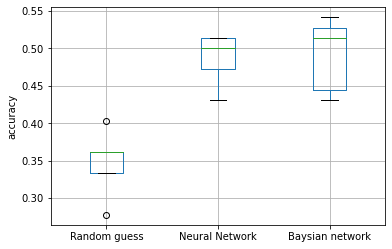

In [136]:
data = []
for i in range(len(rand_accuracies)):
    data.append((rand_accuracies[i],nn_accuracies[i],bn_accuracies[i]))
data = np.array(data)
df = pd.DataFrame(data,
                  columns=['Random guess','Neural Network','Baysian network'])

boxplot = df.boxplot(column=['Random guess','Neural Network','Baysian network'])
boxplot.set_ylabel("accuracy")

(0.4540540540540541, 0.24054054054054055, 0.3054054054054054)


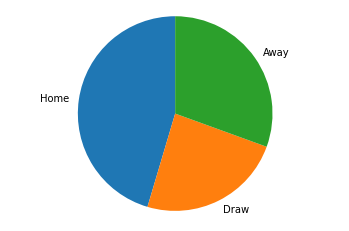

In [85]:
countH = 0
countD = 0
countA = 0
total = 0
for i in range(len(np_labels)):
    if np_labels[i] == 0:
        countH+=1
    elif np_labels[i] == 1:
        countD+=1
    elif np_labels[i] == 2:
        countA+=1
    total += 1
Hrate = countH/total
Drate = countD/total
Arate = countA/total
print(str((Hrate, Drate, Arate)))
labels = 'Home', 'Draw', 'Away'
sizes = [Hrate, Drate, Arate]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal') 

plt.show()

In [134]:
#baysian network

def build_baysian(bays_data, bays_scores, bays_labels):
    
    size = len(bays_data)
    home_score_avg = []
    away_score_avg = []
    home_conceded_avg = []
    away_conceded_avg = []
    home_shots_on_avg = []
    away_shots_on_avg = []
    home_shots_on_conceded_avg = []
    away_shots_on_conceded_avg = []
    home_shots_avg = []
    away_shots_avg = []
    home_shots_conceded_avg = []
    away_shots_conceded_avg = []
    score_dif = []
    conc_dif = []
    a_score = []
    h_score = []
    results = []
    count = 0

    while True:
        home_score_avg.append(round(bays_data[count][0][1],0))
        away_score_avg.append(round(bays_data[count][1][1],0))
        home_conceded_avg.append(round(bays_data[count][0][9],0))
        away_conceded_avg.append(round(bays_data[count][1][9],0))
        home_shots_on_avg.append(round(bays_data[count][0][4],0))
        away_shots_on_avg.append(round(bays_data[count][1][4],0))
        home_shots_on_conceded_avg.append(round(bays_data[count][0][12],0))
        away_shots_on_conceded_avg.append(round(bays_data[count][1][12],0))
        home_shots_avg.append(round(bays_data[count][0][3],0))
        away_shots_avg.append(round(bays_data[count][1][3],0))
        home_shots_conceded_avg.append(round(bays_data[count][0][11],0))
        away_shots_conceded_avg.append(round(bays_data[count][1][11],0))

        h_score.append(bays_scores[count][0])
        a_score.append(bays_scores[count][1])
        results.append(int(bays_labels[count]))
        if count >= size-20:
            break
        count +=1

    datas = pd.DataFrame(data={'home': home_score_avg, 
                               'away': away_score_avg,
                               'home_conc': home_conceded_avg,
                               'away_conc': away_conceded_avg,
                               'home_shots_on': home_shots_on_avg,
                               'away_shots_on': away_shots_on_avg,
                               'home_shots_on_conc': home_shots_on_conceded_avg,
                               'away_shots_on_conc': away_shots_on_conceded_avg,
                               'home_shots': home_shots_avg,
                               'away_shots': away_shots_avg,
                               'home_shots_conc': home_shots_conceded_avg,
                               'away_shots_conc': away_shots_conceded_avg,
                               'h_score':h_score,
                               'a_score':a_score,
                               'result': results
                              })

    network =  BayesianModel([('h_score','result'),('a_score','result'),('home', 'h_score'), ('away', 'a_score'), ('home_conc', 'a_score'), ('away_conc', 'h_score'), 
                              ('home_shots', 'home_shots_on'),('away_shots', 'away_shots_on'), ('home_shots_conc', 'home_shots_on_conc'),
                              ('away_shots_conc', 'away_shots_on_conc'), ('home_shots_on', 'home'), ('away_shots_on', 'away'),
                              ('away_shots_on_conc', 'away_conc'),('home_shots_on_conc', 'home_conc')])


    network.fit(datas, estimator=BayesianEstimator)
    return network

In [135]:
def bays_predict(match,network):
    a = (round(match[0][1],0))
    b = (round(match[1][1],0))        
    c = (round(match[0][9],0))
    d = (round(match[1][9],0))
    e = (round(match[0][4],0))
    f = (round(match[1][4],0))
    g = (round(match[0][12],0))
    h = (round(match[1][12],0))
    i = (round(match[0][3],0))
    j = (round(match[1][3],0))
    k = (round(match[0][11],0))
    l = (round(match[1][11],0))
    m = (int(labels[count]))
    test = pd.DataFrame(data={'home': [a],
                              'away': [b],
                              'home_conc': [c],
                              'away_conc': [d],
                              'home_shots_on': [e],
                              'away_shots_on': [f],
                              'home_shots_on_conc': [g],
                              'away_shots_on_conc': [h],
                              'home_shots': [i],
                              'away_shots': [j],
                              'home_shots_conc': [k],
                              'away_shots_conc': [l]
                              })
    prediction = 0
    try: #possibility of unusually high result e.g a team averages 6 goals per game near the start of the season
        res = network.predict_probability(test)
    
        max_prob = res['result_0'][0]

        if res['result_1'][0] > max_prob:
            max_prob = res['result_1'][0]
            prediction = 1
        if res['result_2'][0] > max_prob:
            max_prob = res['result_2'][0]
            prediction = 2
    except:
        print(test)
    return prediction

In [112]:
network = build_baysian(data, scores, labels)
count = 300
rate = 0
while count <= 320:
    predict = bays_predict(data[count],network)
    print(str(count)+" was "+str(scores[count][0])+":"+str(scores[count][1]) +" res:"+str(labels[count]) + " guess:" + str(predict))
    if predict == labels[count]:
        rate += 1
    count += 1
print(rate)

C:\Users\Sam\anaconda3\lib\site-packages\pgmpy\estimators\BayesianEstimator.py:154: UserWarning: pseudo count specified with bdeu prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  warn(
C:\Users\Sam\anaconda3\lib\site-packages\pgmpy\estimators\BayesianEstimator.py:154: UserWarning: pseudo count specified with bdeu prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  warn(
C:\Users\Sam\anaconda3\lib\site-packages\pgmpy\estimators\BayesianEstimator.py:154: UserWarning: pseudo count specified with bdeu prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  warn(
C:\Users\Sam\anaconda3\lib\site-packages\pgmpy\estimators\BayesianEstimator.py:154: UserWarning: pseudo count specified with bdeu prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  warn(
C:\Users\Sam\anaconda3\lib\site-packages\pgmpy\estimators\BayesianEstimator.py:154: UserWarning: pseudo count specified with bdeu prior. It will

300 was 0:1 res:2 guess:0
301 was 3:0 res:0 guess:0
302 was 5:2 res:0 guess:0
303 was 0:2 res:2 guess:0
304 was 3:0 res:0 guess:0
305 was 1:1 res:1 guess:0
306 was 2:2 res:1 guess:0
307 was 2:0 res:0 guess:0
308 was 1:0 res:0 guess:2
309 was 1:0 res:0 guess:0
310 was 2:3 res:2 guess:2
311 was 2:1 res:0 guess:0
312 was 1:1 res:1 guess:2
313 was 5:0 res:0 guess:0
314 was 1:0 res:0 guess:0
315 was 0:1 res:2 guess:0
316 was 1:3 res:2 guess:2
317 was 0:0 res:1 guess:2
318 was 1:1 res:1 guess:0
319 was 0:3 res:2 guess:2
320 was 0:4 res:2 guess:0
11


In [121]:
def evaluate_baysian(network ,data, test_labels):
    results = []
    for i in range(len(test_labels)):
        prediction = bays_predict(data[i],network)
        results.append(prediction)
    results = np.array(results)
    
    r = tf.keras.metrics.Accuracy()
    r.update_state(test_labels, results)
    return(r.result().numpy())
